In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import networkx as nx

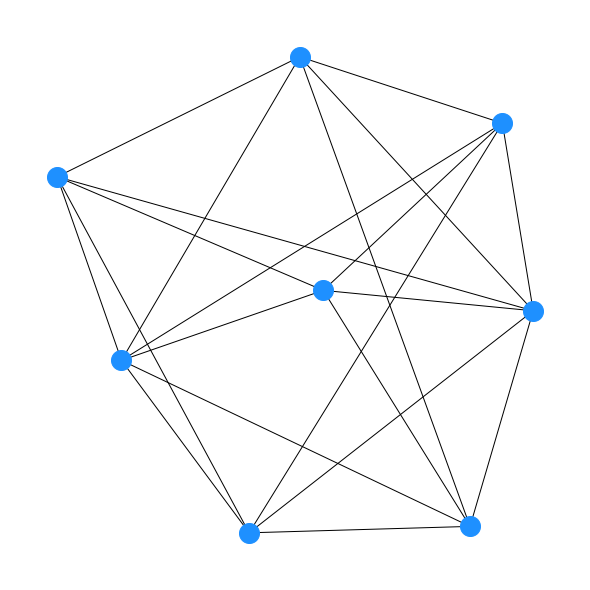

In [33]:
plt.figure(figsize=(8,8))
G = nx.turan_graph(8,3)  # 5x5 grid
pos = nx.spring_layout(G, scale=2, seed=902, iterations=100)
nx.draw(G, pos, node_color = 'dodgerblue', node_size=400)

connect={}
coordinate = {}
nodes = []
for e in G.edges:
    connect[e[0]+1,e[1]+1]=1
    nodes.append(e[0]+1)
    nodes.append(e[1]+1)
    
nodes= list(set(nodes))
N= len(nodes)
for n in G.nodes:
    coordinate[n+1,'X']=pos[n][0]
    coordinate[n+1,'Y']=pos[n][1]
plt.savefig('base_graph'+  ' .png', format='png', dpi=400)
plt.show()

In [38]:
Nc = 5
model = AbstractModel()
model.c = RangeSet(5)
model.i = RangeSet(N)
model.j = Set(initialize=model.i)
model.U = Var(model.i,model.c, within=Binary)
model.Y = Var(model.c, bounds=(0,1), within=Reals)

def rule_C1(model,i):
    return sum(model.U[i,c] for c in model.c) == 1
model.C1 = Constraint(model.i, rule=rule_C1)
    
def rule_C2(model,i,j,c):
    if (i,j) in connect:
        return model.U[i,c]+model.U[j,c]<= 1
    else:
        return Constraint.Skip 
model.C2 = Constraint(model.i,model.j, model.c, rule=rule_C2)
    
def rule_C3(model,i,c):
    return model.U[i,c]<= model.Y[c]
model.C3 = Constraint(model.i, model.c, rule=rule_C3)
      
def rule_C4(model,c):
    if c+1<= Nc:
        return model.Y[c+1]<= model.Y[c]
    else:
        return Constraint.Skip 
model.C4 = Constraint(model.c, rule=rule_C4)
        
def rule_OF(model):
    return sum(model.Y[c] for c in model.c) 
model.obj = Objective(rule= rule_OF, sense=minimize)

opt = SolverFactory('cbc')
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)  
print(value(instance.obj))

feasible
3.0


In [39]:
for c in instance.c:
    print(c, value(instance.Y[c]))

1 1.0
2 1.0
3 1.0
4 0.0
5 0.0


1 3
2 3
3 2
4 2
5 2
6 1
7 1
8 1


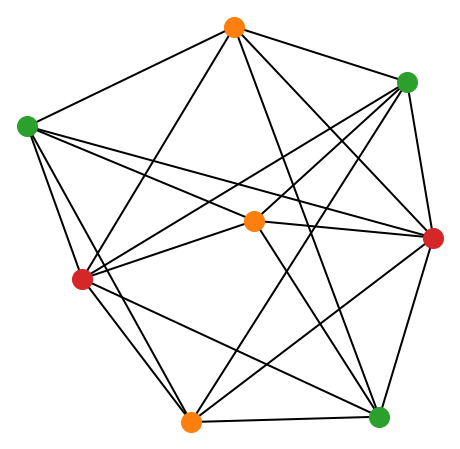

In [40]:
KOLOR=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(8,8))
for (f,t) in connect:
    x1= coordinate[f,'X']
    y1= coordinate[f,'Y']
    x2= coordinate[t,'X']
    y2= coordinate[t,'Y']
    plt.plot([x1,x2],[y1,y2], 'k-',lw=2, zorder= -1)
for i in instance.i:
    x1= coordinate[i,'X']
    y1= coordinate[i,'Y']
    cindex= int(sum(value(instance.U[i,c])*c for c in instance.c))
    plt.scatter(x1,y1,s=400, c=KOLOR[cindex], zorder= 2)
        
plt.axis('off')
plt.savefig('Vertex Coloring'+  ' .png', format='png', dpi=400)
